# <span style="font-family:Georgia; font-size:50em;">Hackathon Santander Data Challenge</span>

---



##### **Time “Zin” (#29)**
- Abelardo Borges Fukasawa (Data Engineer)   
- Lucas Hideki Ueda (Data Scientist)  
- Victor Wildner (Data Analyst)  
- Vivian Estequi (Business Analyst)  
- Wesley Rischioni (Colaborador Santander)


In [ ]:
from google.colab import auth, drive
from google.cloud import bigquery

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

In [ ]:
def bigquery_client_setup(project_id, use_bigquery_display=True):
    '''
    Authenticates colab user and initilizes a BigQuery client. Code verification
    may be needed, so click at the displayed link, allow API usage and copy  and
    paste the provided verification code in order to obtain access.

    Parameters
    ------------
    project_id (str): 
        Your Google Cloud project_id. For more info, see 
        https://cloud.google.com/resource-manager/docs/creating-managing-projects
    use_bigquery_display (bool): 
        User choice of using the bigquery display on colab. If False, pandas 
        default display will be used.

    Returns
    ------------
    client:
        Google BigQuery client to be used in any API call.

    '''
    try:
        auth.authenticate_user()
        print('Authenticated')
        client = bigquery.Client(project=project_id)
        print('BigQuery Client created successfully')
    except:
        print('Authentication failed')
    if use_bigquery_display:
        %load_ext google.colab.data_table
        print('Using BigQuery display')
    else:
        %unload_ext google.colab.data_table
        print('Using Pandas display')
    return client

In [ ]:
PROJECT_ID = 'santander-datathon'
client = bigquery_client_setup(PROJECT_ID)
drive.mount('/content/drive')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

Authenticated
BigQuery Client created successfully
The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table
Using BigQuery display
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pmc = client.query("""
    SELECT
        string_field_0 AS uf,
        string_field_1 AS atividade,
        string_field_2 AS indice,
        date_field_3 AS data_,
        double_field_4 AS indiceFixo,
        string_field_5 AS indiceAjustado,
        string_field_6 AS indiceFixoDeltaMes,
        double_field_7 AS indiceFixoDeltaAno,
        double_field_8 AS indiceFixoDeltaAcumMes,
        double_field_9 AS indiceFixoDeltaAcumAno
     FROM `santander-datathon.ibge.pmc`
""").to_dataframe()

pmc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9802 entries, 0 to 9801
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uf                      9802 non-null   object 
 1   atividade               9802 non-null   object 
 2   indice                  9802 non-null   object 
 3   data_                   9802 non-null   object 
 4   indiceFixo              9802 non-null   float64
 5   indiceAjustado          9802 non-null   object 
 6   indiceFixoDeltaMes      9802 non-null   object 
 7   indiceFixoDeltaAno      9802 non-null   float64
 8   indiceFixoDeltaAcumMes  9802 non-null   float64
 9   indiceFixoDeltaAcumAno  9802 non-null   float64
dtypes: float64(4), object(6)
memory usage: 765.9+ KB


# **1. EDA**

Começamos nossa análise avaliando o relatório do PMC (Pesquisa Mensal Comércio), avaliando o impacto da CAVID-19 no Varejo.

In [ ]:
# Removendo atividades que estão consolidadas em outras linhas
pmc = pmc[pmc.atividade !='Móveis'] 
pmc = pmc[pmc.atividade !='Hipermercados e supermercados']
pmc = pmc[pmc.atividade !='Eletrodomésticos']

# Ajuste data/strings
pmc['data_']   = pmc.data_.map(lambda x: datetime.strptime(str(x),'%Y-%d-%m') if str(x).strip() != 'nan' else np.nan)
pmc['indiceFixoDeltaMes'] = pmc.indiceFixoDeltaMes.map(lambda x: 0 if x == '-' else float(x))
pmc['indiceAjustado'] = pmc.indiceAjustado.map(lambda x: 0 if x == '-' else float(x))

In [ ]:
pmc.head(2)

,uf,atividade,indice,data_,indiceFixo,indiceAjustado,indiceFixoDeltaMes,indiceFixoDeltaAno,indiceFixoDeltaAcumMes,indiceFixoDeltaAcumAno
0,Brasil,Combustíveis e lubrificantes,Índice de volume de vendas no comércio varejis...,2018-01-01,76.5,78.8,-0.4,-4.1,-4.1,-3.1
1,Brasil,Combustíveis e lubrificantes,Índice de volume de vendas no comércio varejis...,2018-02-01,70.9,78.2,-0.8,-6.4,-5.3,-2.9


In [ ]:
%%capture
# ajuste base para plot

df_plot = pmc[pmc.uf=='Brasil'][pmc.indice=='Índice de volume de vendas no comércio varejista ampliado'].pivot_table(values=['indiceFixo'],columns=['data_'],index=['atividade','indice'],aggfunc=np.sum)\
          .reset_index().rename_axis(None).rename_axis(None)

df_plot.columns = df_plot.columns.droplevel()
df_plot_col = ['atividade','indice', '2018-01-01' ,
       '2018-02-01' , '2018-03-01' , '2018-04-01' ,
       '2018-05-01' , '2018-06-01' , '2018-07-01' ,
       '2018-08-01' , '2018-09-01' , '2018-10-01' ,
       '2018-11-01' , '2018-12-01' , '2019-01-01' ,
       '2019-02-01' , '2019-03-01' , '2019-04-01' ,
       '2019-05-01' , '2019-06-01' , '2019-07-01' ,
       '2019-08-01' , '2019-09-01' , '2019-10-01' ,
       '2019-11-01' , '2019-12-01' , '2020-01-01' ,
       '2020-02-01' , '2020-03-01' , '2020-04-01' ,
       '2020-05-01']
df_plot.columns = df_plot_col
df_plot.set_index(['atividade','indice'])

In [ ]:
sns.set_style("whitegrid")


In [ ]:
plt.figure(figsize=(25,12))
ax = sns.lineplot(data=df_plot.set_index(['atividade','indice']).T, palette="Paired", linewidth=2.5,dashes=False)
plt.title('Volume Vendas - Brasil',fontsize=20)
plt.tick_params(labelsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45);

Ok, todos os setores tiveram baixas, em especial no mês de abril, qual setor teve a maior queda relativa?

In [ ]:
%%capture
# ajuste base para plot

df_plot = pmc[pmc.uf=='Brasil'][pmc.indice=='Índice de volume de vendas no comércio varejista ampliado'].pivot_table(values=['indiceFixoDeltaMes'],columns=['data_'],index=['atividade','indice'],aggfunc=np.sum)\
          .reset_index().rename_axis(None).rename_axis(None)

df_plot.columns = df_plot.columns.droplevel()
df_plot.columns = df_plot_col
df_plot.set_index(['atividade','indice'])

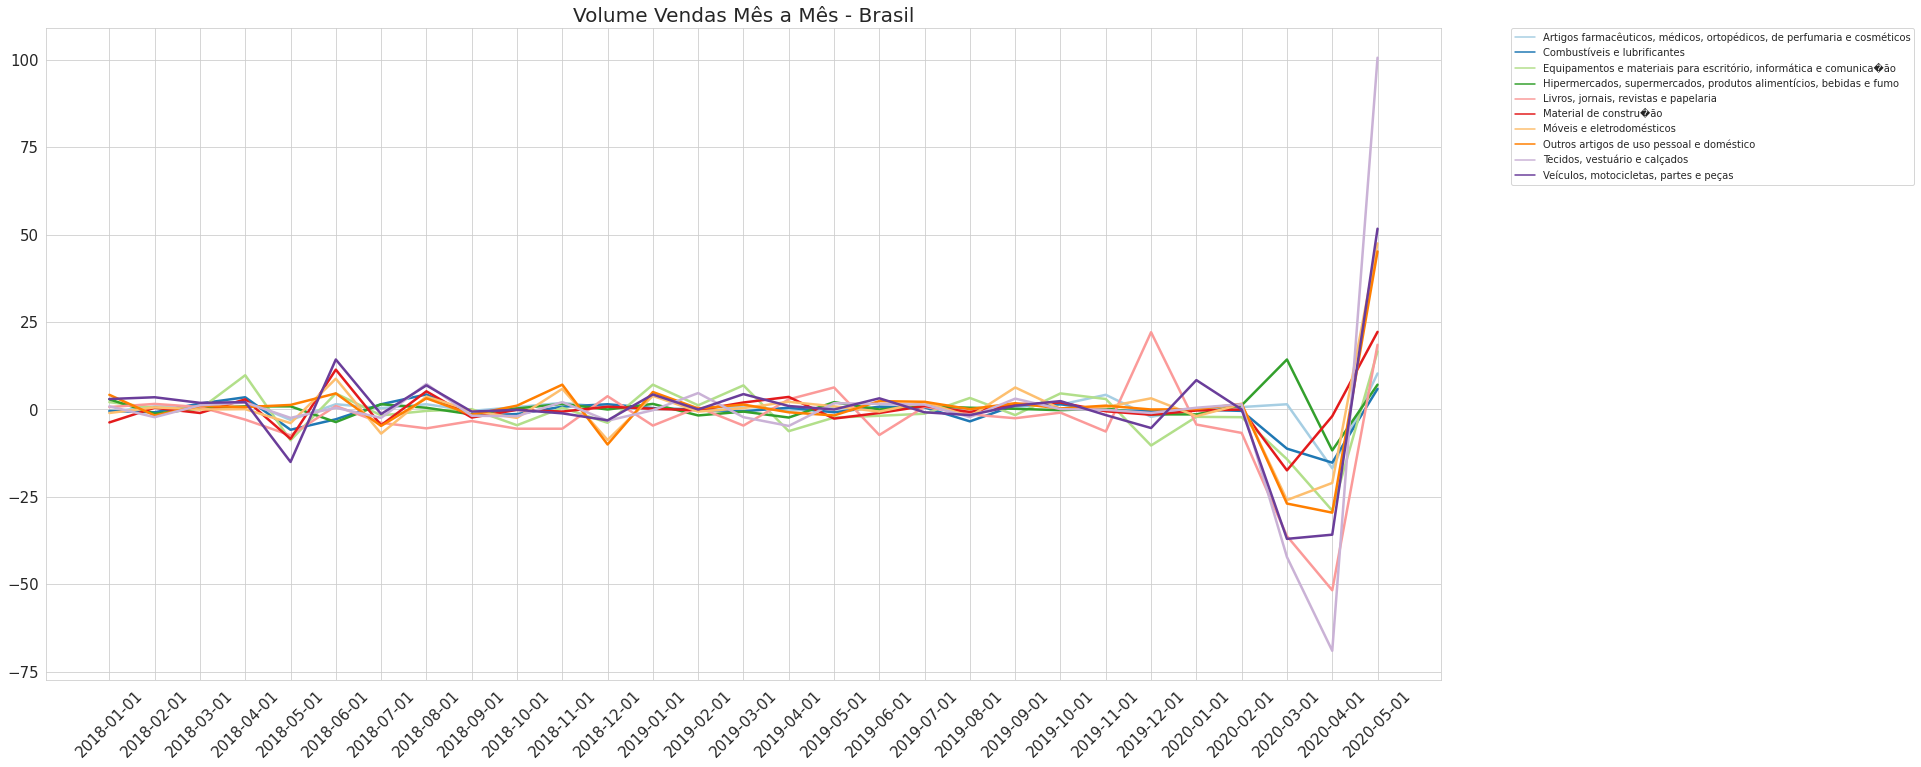

In [ ]:
plt.figure(figsize=(25,12))
ax = sns.lineplot(data=df_plot.set_index(['atividade','indice']).T, palette="Paired", linewidth=2.5,dashes=False)
plt.title('Volume Vendas Mês a Mês - Brasil',fontsize=20)
plt.tick_params(labelsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45);

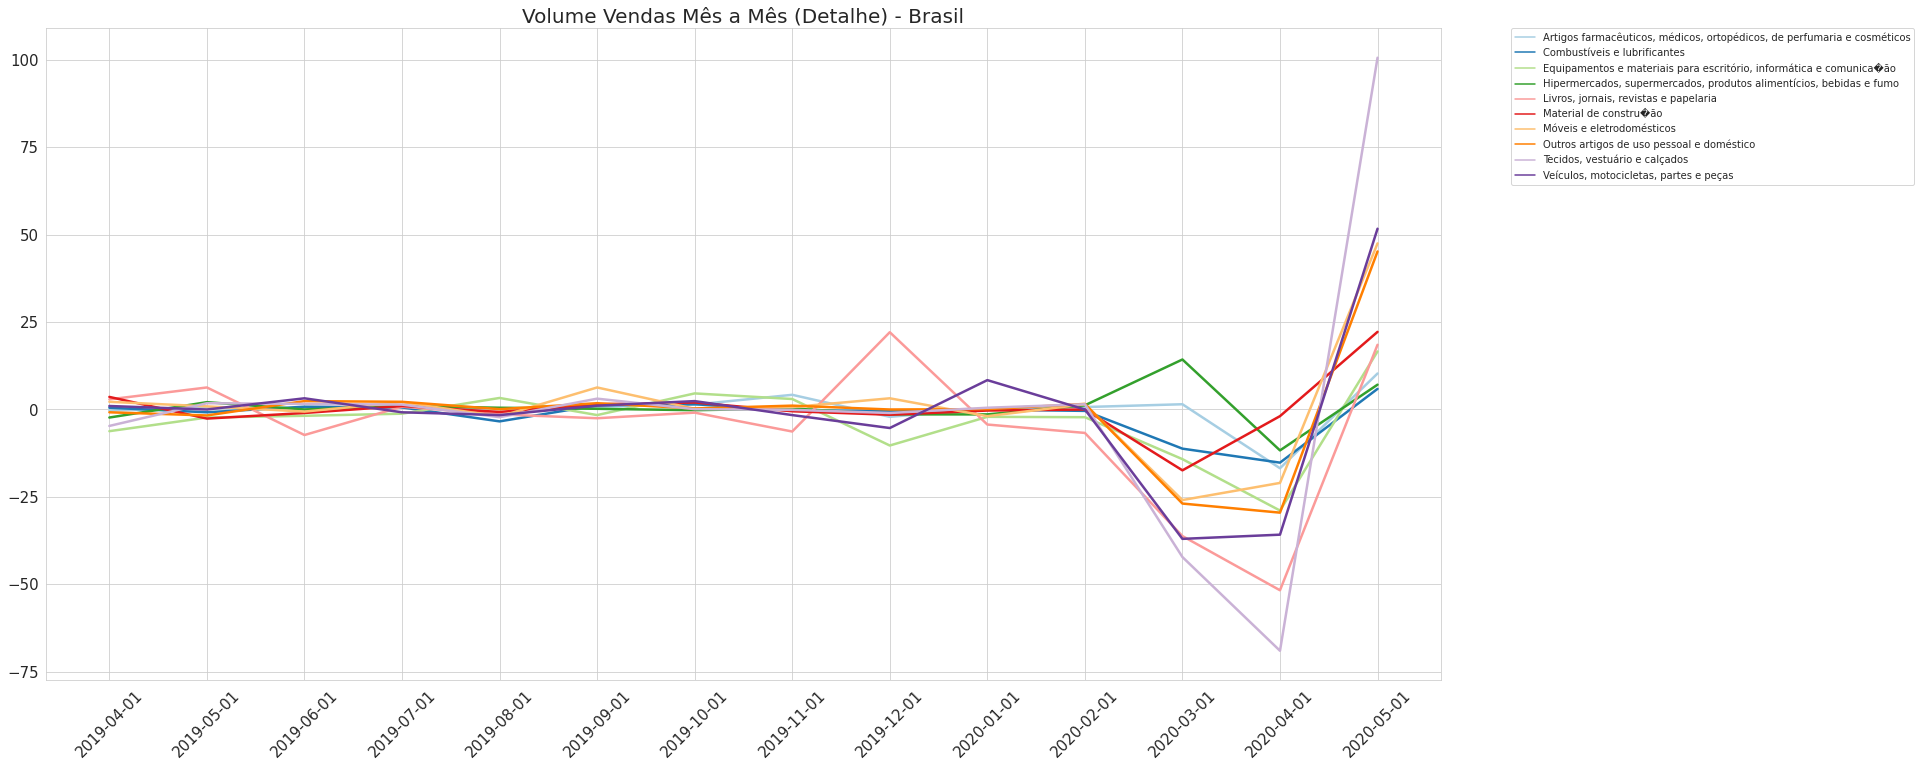

In [ ]:
plt.figure(figsize=(25,12))
ax = sns.lineplot(data=df_plot.set_index(['atividade','indice']).T[15:], palette="Paired", linewidth=2.5,dashes=False)
plt.title('Volume Vendas Mês a Mês (Detalhe) - Brasil',fontsize=20)
plt.tick_params(labelsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45);

In [ ]:
Como é o comportamento ano x ano?

Object `ano` not found.


In [ ]:
%%capture
# ajuste base para plot

df_plot = pmc[pmc.uf=='Brasil'][pmc.indice=='Índice de volume de vendas no comércio varejista ampliado'].pivot_table(values=['indiceFixoDeltaAno'],columns=['data_'],index=['atividade','indice'],aggfunc=np.sum)\
          .reset_index().rename_axis(None).rename_axis(None)

df_plot.columns = df_plot.columns.droplevel()
df_plot.columns = df_plot_col
df_plot.set_index(['atividade','indice'])

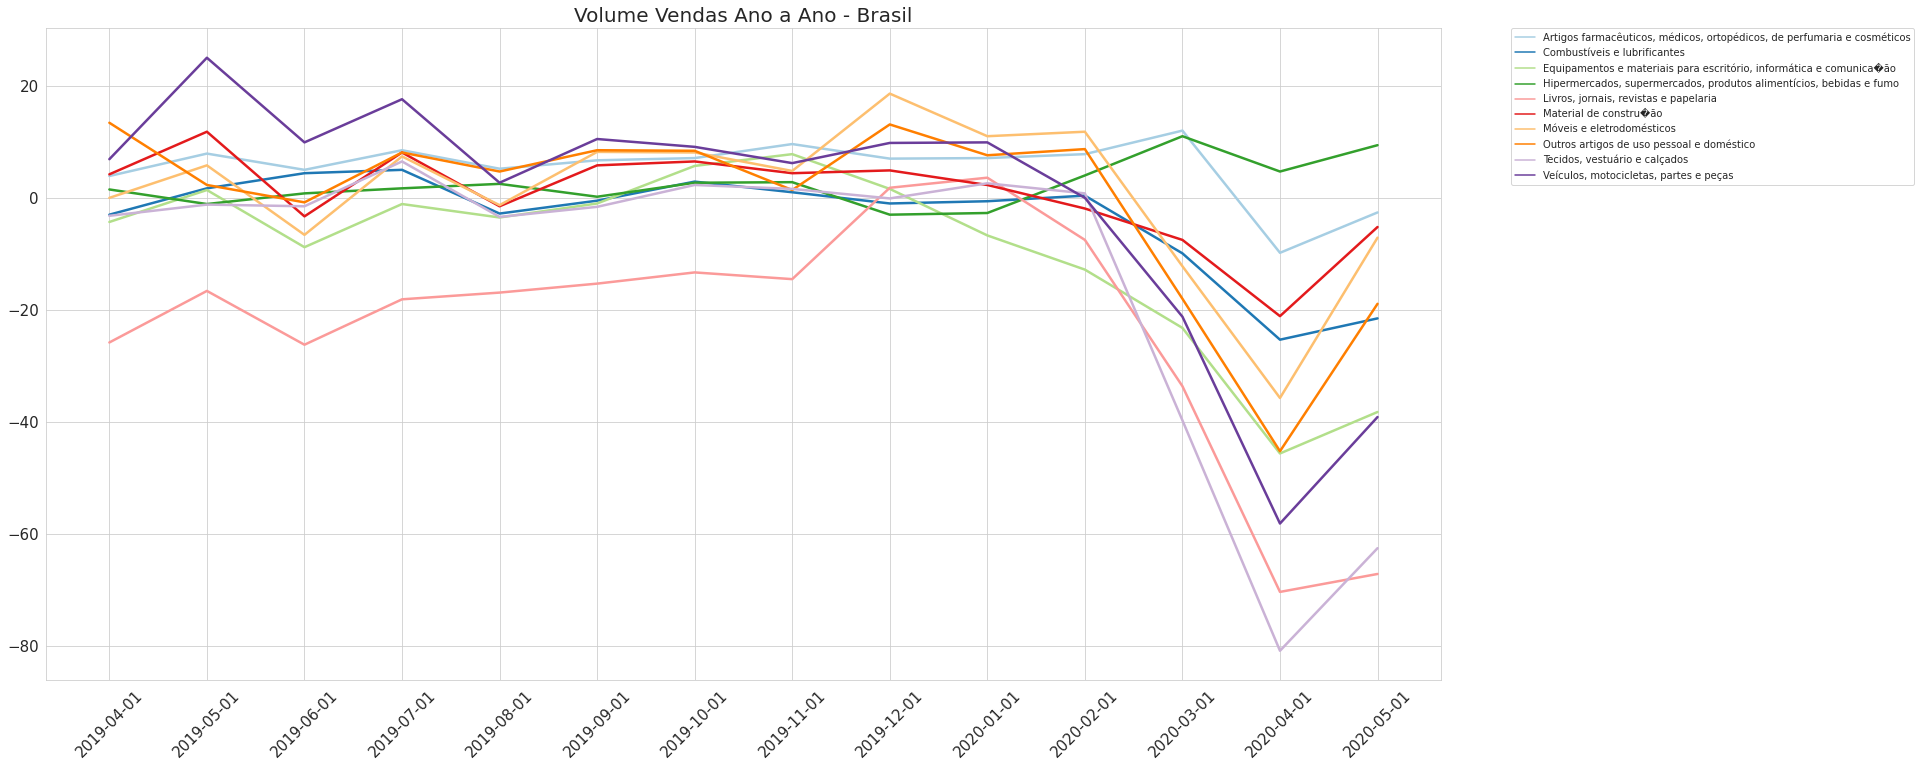

In [ ]:
plt.figure(figsize=(25,12))
ax = sns.lineplot(data=df_plot.set_index(['atividade','indice']).T[15:], palette="Paired", linewidth=2.5,dashes=False)
plt.title('Volume Vendas Ano a Ano - Brasil',fontsize=20)
plt.tick_params(labelsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45);

Vamos separar algumas categorias e comparar com a variação média de todos os setores

In [ ]:
%%capture
# ajuste base para plot

df_plot_ = pmc[pmc.uf=='Brasil'][pmc.indice=='Índice de volume de vendas no comércio varejista ampliado'].pivot_table(values=['indiceFixoDeltaAno'],columns=['data_'],index=['indice'],aggfunc=np.mean) \
          .reset_index().rename_axis(None).rename_axis(None)
df_plot_['atividade']  = 'Média de crescimento Atividades - Brasil'

df_plot_.columns = df_plot_.columns.droplevel()
df_plot_col_ = ['indice', '2018-01-01' ,
       '2018-02-01' , '2018-03-01' , '2018-04-01' ,
       '2018-05-01' , '2018-06-01' , '2018-07-01' ,
       '2018-08-01' , '2018-09-01' , '2018-10-01' ,
       '2018-11-01' , '2018-12-01' , '2019-01-01' ,
       '2019-02-01' , '2019-03-01' , '2019-04-01' ,
       '2019-05-01' , '2019-06-01' , '2019-07-01' ,
       '2019-08-01' , '2019-09-01' , '2019-10-01' ,
       '2019-11-01' , '2019-12-01' , '2020-01-01' ,
       '2020-02-01' , '2020-03-01' , '2020-04-01' ,
       '2020-05-01','atividade']
df_plot_.columns = df_plot_col_
df_plot_ = df_plot_[df_plot_col]
df_plot_.set_index(['atividade','indice'])

In [ ]:
df_plot = pd.concat([df_plot_,df_plot])

In [ ]:
#Filtro Categorias a serem analisadas
categorias = ['Equipamentos e materiais para escritório, informática e comunica�ão', 'Material de constru�ão'	,'Móveis e eletrodomésticos','Tecidos, vestuário e calçados','Veículos, motocicletas, partes e peças']

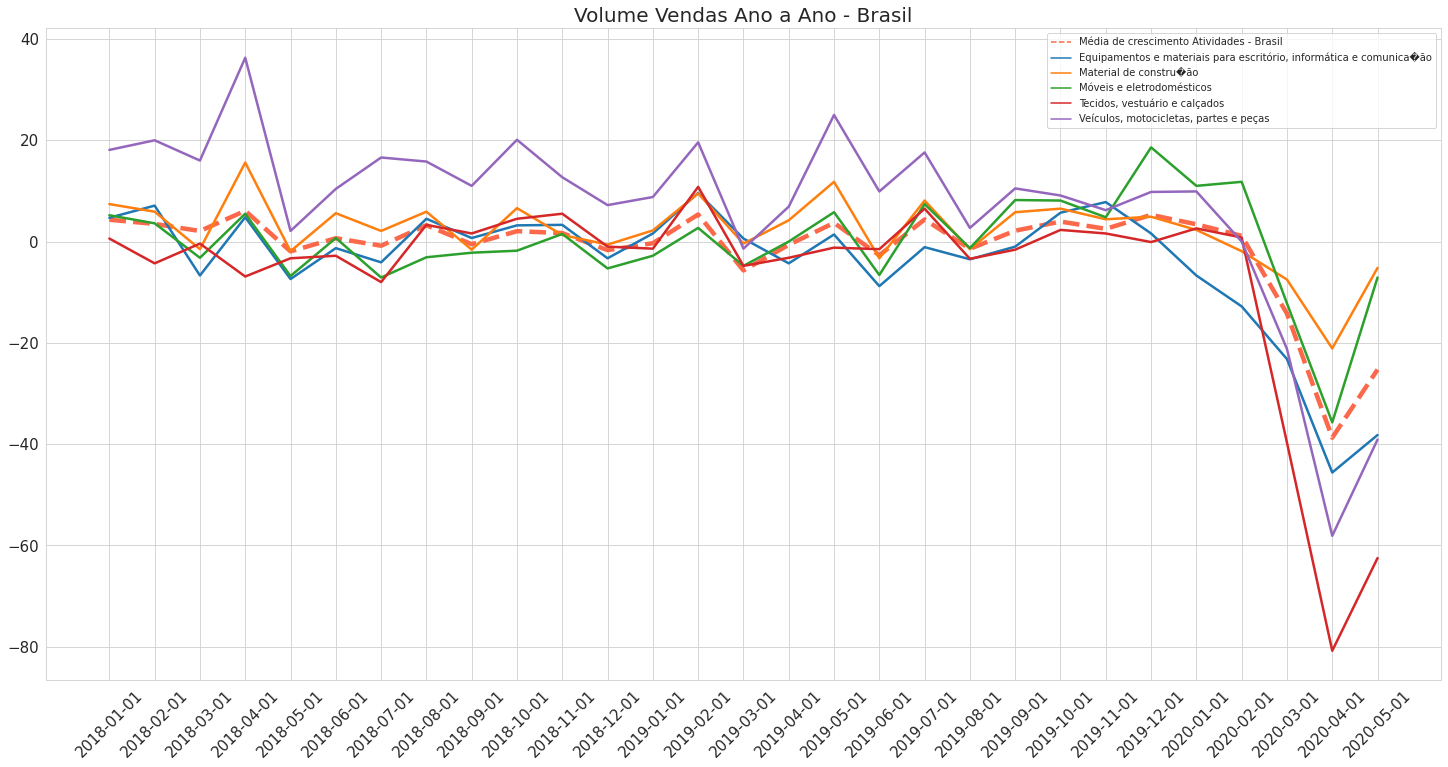

In [ ]:
plt.figure(figsize=(25,12))
ax_ = sns.lineplot(data=df_plot[df_plot.atividade == 'Média de crescimento Atividades - Brasil'].set_index(['atividade','indice']).T,palette='Reds',linewidth=4.5,style='--')
ax_.lines[0].set_linestyle("--")
ax = sns.lineplot(data=df_plot[df_plot.atividade.isin(categorias)].set_index(['atividade','indice']).T, linewidth=2.5,dashes=False)

plt.title('Volume Vendas Ano a Ano - Brasil',fontsize=20)
plt.tick_params(labelsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
leg = ax.legend()
leg_lines = leg.get_lines()
leg_lines[0].set_linestyle("--")


plt.xticks(rotation=45);

Podemos ver que a categoria de Tecidos, vestuário e calçado que sempre acompanhou a média brasileira, acabou tendo a maior queda;  
A categoria de veículos, que tinha um desempenho acima da média, também sofreu  bastante;  
Móveis e eletrodomésticos, assim como materiais de construção conseguiram sobressair à média brasileira.


Análisando um pouco mais o setor de Móveis e Eletrodomésticos:


In [ ]:
pmc[pmc.uf == 'Brasil'][pmc.atividade == 'Móveis e eletrodomésticos'][pmc.indice=='Índice de receita nominal de vendas no comércio varejista ampliado'][pmc.data_ > '2020-01-01'][['uf','atividade','indice','data_','indiceFixoDeltaMes','indiceFixoDeltaAno']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,uf,atividade,indice,data_,indiceFixoDeltaMes,indiceFixoDeltaAno
460,Brasil,Móveis e eletrodomésticos,Índice de receita nominal de vendas no comérci...,2020-02-01,1.1,9.6
461,Brasil,Móveis e eletrodomésticos,Índice de receita nominal de vendas no comérci...,2020-03-01,-27.2,-15.2
462,Brasil,Móveis e eletrodomésticos,Índice de receita nominal de vendas no comérci...,2020-04-01,-22.2,-38.8
463,Brasil,Móveis e eletrodomésticos,Índice de receita nominal de vendas no comérci...,2020-05-01,51.5,-9.9


O setor teve uma retomada de 51.5% em maio comparado a abril  em receita, porém uma queda de aproximadamente 10% quando comparado ao mesmo período do ano passado.

Segundo dados pulicados pelo Mercado Livre, houve um aumento de 28% de compradores em sua base. (Aprox. 2,6 MM de Novos Clientes)

![texto alternativo](https://i.ibb.co/VNb7qfr/Capture.png)

Destes novos compradores, cerca de 9% ingressaram pela categoria de Casa, Móveis e Jardim

![texto alternativo](https://i.ibb.co/f8zd8bS/Capture1.png)

Segundo estudo e pesquisa publicado no site RD Station realizada com PMEs:

![texto alternativo](https://i.ibb.co/0QqKCP6/Capture2.png)

# Solução 



In [1]:
# Baixando as dependências e a solução
!pip install --upgrade --user git+https://github.com/GeneralMills/pytrends
! git clone https://github.com/lucashueda/datathon_santander_2020.git
%cd datathon_santander_2020

  Cloning https://github.com/GeneralMills/pytrends to /tmp/pip-req-build-_vq6mx3q
  Running command git clone -q https://github.com/GeneralMills/pytrends /tmp/pip-req-build-_vq6mx3q
  Created wheel for pytrends: filename=pytrends-4.7.3-cp36-none-any.whl size=15250 sha256=caca34bf71277265f94b4f4f93fcc2227de8142ae86c9fad1d610564195e242e
  Stored in directory: /tmp/pip-ephem-wheel-cache-av5_vcgy/wheels/f6/49/f7/a4785ff2079f1cc793186a60d40863c5d4ee9863e2b315a0bd
Successfully built pytrends
Cloning into 'datathon_santander_2020'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 49 (delta 12), reused 17 (delta 7), pack-reused 26
Unpacking objects: 100% (49/49), done.
/content/datathon_santander_2020


# Fotos dos itens

O usuário vem e coloca as fotos tiradas na pasta "test_images"

In [4]:
!ls test_images

fone.jpg  impressora.jpg  roteador.jpg


In [11]:
# Visualizando as imagens
from main import get_image
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

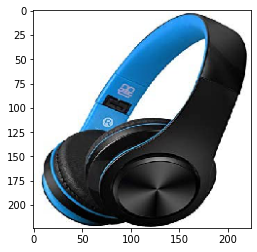

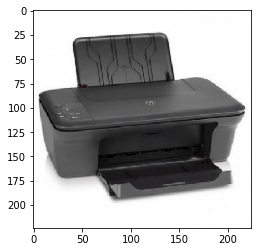

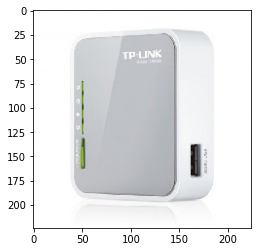

In [7]:
fone, x = get_image('test_images/fone.jpg')
impressora, x = get_image('test_images/impressora.jpg')
roteador, x = get_image('test_images/roteador.jpg')

# Exibindo as fotos
plt.imshow(fone)
plt.show()

plt.imshow(impressora)
plt.show()

plt.imshow(roteador)
plt.show()

# Reconhecimento de inventário

A seguir a nossa solução pega as fotos da pasta "test_images" e identifica que tipo de item ela é.

In [8]:
# só precisa rodar essa célula, a inferência é rápida mesmo sem uso de GPU
!python3 main.py

Using TensorFlow backend.
2020-08-02 23:54:59.335410: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-08-02 23:55:02.244822: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-08-02 23:55:02.248168: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-08-02 23:55:02.248231: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c6d80d61795f): /proc/driver/nvidia/version does not exist
2020-08-02 23:55:02.254774: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2200000000 Hz
2020-08-02 23:55:02.255027: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x17cd480 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-08-02 23:55:0

In [9]:
# Um inventário simples no formato csv é salvo para facilitar demais progressões na convergência digital (aqui poderia ser salvo em formatos
# como sql, mongo a depender de um possível website, a saída é customizável)
!ls # Note o arquivo "inventario.csv" criado

inventario.csv	main.py        __pycache__  test_images
LICENSE		model_weights  README.md    trends.py


In [12]:
pd.read_csv("inventario.csv")

,inventario
0,Roteador
1,Impressora
2,Fone de ouvido


# Google Trends

Em seguida é possível, a partir dos nomes dos itens do inventário classificá-los em ordem de procura pelo consumidor

In [13]:
!python3 trends.py --kw Roteador Impressora Fone --me '12'

['Roteador', 'Impressora', 'Fone'] 12


In [14]:
!ls # um novo arquivo chamado "local_ordered.csv" foi criado, onde indica a ordenação dos itens do inventário, com base na procura dos clientes na internet


inventario.csv	local_ordered.csv  model_weights  README.md    trends.py
LICENSE		main.py		   __pycache__	  test_images


In [15]:
import pandas as pd
pd.read_csv('local_ordered.csv')

,produto,score
0,Roteador,0.329167
1,Impressora,0.283333
2,Fone,0.212500


# Visualização

O usuário só terá acesso a um painel que mostre facilmente quais produtos ele deve focar ou não em propagandas e ofertas.

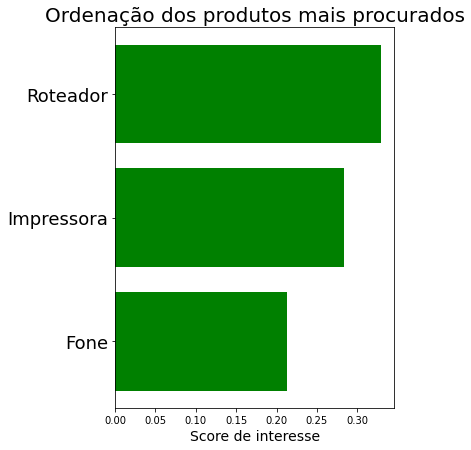

In [26]:
import numpy as np
plt.figure(figsize=(5,7))
plt.title("Ordenação dos produtos mais procurados",fontsize = 20)
plt.barh(np.arange(3), pd.read_csv('local_ordered.csv').sort_values(by='score')['score'] , color = 'green')
plt.yticks(np.arange(3), pd.read_csv('local_ordered.csv').sort_values(by='score')['produto'], fontsize = 18)
plt.xlabel("Score de interesse", fontsize = 14)
plt.show()

# Bônus

O cliente pode acompanhar o interesse dos usuários em tempo real e nos itens de seu interesse.

In [27]:
# Basta chamar a etapa de trends colocando os itens que se deseja que a requisição é feita em tempo real
!python3 trends.py --kw celular notebook fogão camiseta geladeira --me '12'

['celular', 'notebook', 'fogão', 'camiseta', 'geladeira'] 12


In [30]:
import pandas as pd
pd.read_csv('local_ordered.csv').sort_values(by='score', ascending = False)

,produto,score
2,fogão,0.800000
1,notebook,0.712500
4,geladeira,0.483333
0,celular,0.379167
3,camiseta,-0.058333
